In [ ]:
import zipfile
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Step 1: Unzip the uploaded file
zip_file_path = 'airpollution.zip'
extract_dir = './airpollution'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

clean_dir = os.path.join(extract_dir, 'clean')
poll_dir = os.path.join(extract_dir, 'polluted')

In [ ]:
# Step 2: Custom dataset class
class AirPollutionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

In [ ]:
# Step 3: Load images
def load_images_from_directory(directory, label):
    image_paths = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(directory, filename)
            image_paths.append(img_path)
            labels.append(label)
    return image_paths, labels

clean_paths, clean_labels = load_images_from_directory(clean_dir, 0)
poll_paths, poll_labels = load_images_from_directory(poll_dir, 1)

all_paths = clean_paths + poll_paths
all_labels = clean_labels + poll_labels

In [ ]:
# Step 4: Train-test split
train_paths, test_paths, y_train, y_test = train_test_split(all_paths, all_labels, test_size=0.2, random_state=42)

In [ ]:
# Step 5: Transforms
train_transform = transforms.Compose([
    transforms.Resize((108, 162)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, shear=0.2, scale=(0.9, 1.1)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((108, 162)),
    transforms.ToTensor()
])

In [ ]:
# Step 6: Datasets and Dataloaders
train_dataset = AirPollutionDataset(train_paths, y_train, transform=train_transform)
test_dataset = AirPollutionDataset(test_paths, y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [69]:
# Step 7: Define model
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 2, kernel_size=3),  # CNN 1
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(2, 4, kernel_size=3),  # CNN 2
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(4, 8, kernel_size=3),  # CNN 3
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, kernel_size=3),  # CNN 4
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 16, kernel_size=3),  # CNN 5
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d(1)  # GlobalAveragePooling2D equivalent
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(-1, 1)

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNNClassifier().to(device)

criterion = nn.BCEWithLogitsLoss()  # since we already have sigmoid at the end
optimizer = optim.SGD(model.parameters(), lr=0.1)

Using device: cuda


In [71]:
num_epochs = 35
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        running_loss += loss.item()

    accuracy = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {accuracy*100:.2f}%")

Epoch 1/35, Loss: 50.2557, Accuracy: 54.88%
Epoch 2/35, Loss: 50.1541, Accuracy: 55.49%
Epoch 3/35, Loss: 50.0725, Accuracy: 55.49%
Epoch 4/35, Loss: 47.2414, Accuracy: 58.77%
Epoch 5/35, Loss: 35.0488, Accuracy: 78.26%
Epoch 6/35, Loss: 30.0181, Accuracy: 83.36%
Epoch 7/35, Loss: 28.2959, Accuracy: 84.40%
Epoch 8/35, Loss: 26.9376, Accuracy: 85.18%
Epoch 9/35, Loss: 26.9402, Accuracy: 85.22%
Epoch 10/35, Loss: 25.5482, Accuracy: 85.96%
Epoch 11/35, Loss: 25.0295, Accuracy: 85.96%
Epoch 12/35, Loss: 26.2081, Accuracy: 84.87%
Epoch 13/35, Loss: 25.8641, Accuracy: 86.04%
Epoch 14/35, Loss: 25.0853, Accuracy: 86.73%
Epoch 15/35, Loss: 25.4116, Accuracy: 86.21%
Epoch 16/35, Loss: 25.1654, Accuracy: 86.47%
Epoch 17/35, Loss: 24.9195, Accuracy: 85.74%
Epoch 18/35, Loss: 24.3379, Accuracy: 86.78%
Epoch 19/35, Loss: 24.4380, Accuracy: 86.99%
Epoch 20/35, Loss: 24.2443, Accuracy: 87.04%
Epoch 21/35, Loss: 24.4368, Accuracy: 87.47%
Epoch 22/35, Loss: 23.6216, Accuracy: 87.04%
Epoch 23/35, Loss: 

In [72]:
# Step 10: Evaluation
model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # Match shape [batch_size, 1]

        outputs = model(images)
        probs = torch.sigmoid(outputs)  # Apply sigmoid during evaluation
        preds = (probs > 0.5).float()

        correct += (preds == labels).sum().item()

test_accuracy = correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 84.46%


In [73]:
# Step 11: Save model
torch.save(model.state_dict(), 'air_poll_classifier_sgd2to32_pytorch.pth')

In [ ]:
# Define prediction function
def predict_air_quality(img_path, model, device):
    transform = transforms.Compose([
        transforms.Resize((108, 162)),
        transforms.ToTensor(),  # Converts to [0,1] and changes to C x H x W
    ])

    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(img_tensor)
        prediction = (output > 0.5).float().item()

    return 'polluted' if prediction == 1.0 else 'clean'

In [ ]:
loaded_model = CNNClassifier()
loaded_model.load_state_dict(torch.load("air_poll_classifier_sgd2to32_pytorch.pth"))
loaded_model = loaded_model.to(device)
loaded_model.eval()

CNNClassifier(
  (features): Sequential(
    (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): AdaptiveAvgPool2d(output_size=1)
  )
  (classifier): Sequential(
    (0): Fl

In [ ]:
# Extract zip file
zip_file_path = 'test.zip'
extract_dir = './test'

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Contents extracted to {extract_dir}")

Contents extracted to ./test


In [ ]:
# Get image list
folder_path = './test/'
all_files = os.listdir(folder_path)
images = [file for file in all_files if file.lower().endswith('.jpg')]

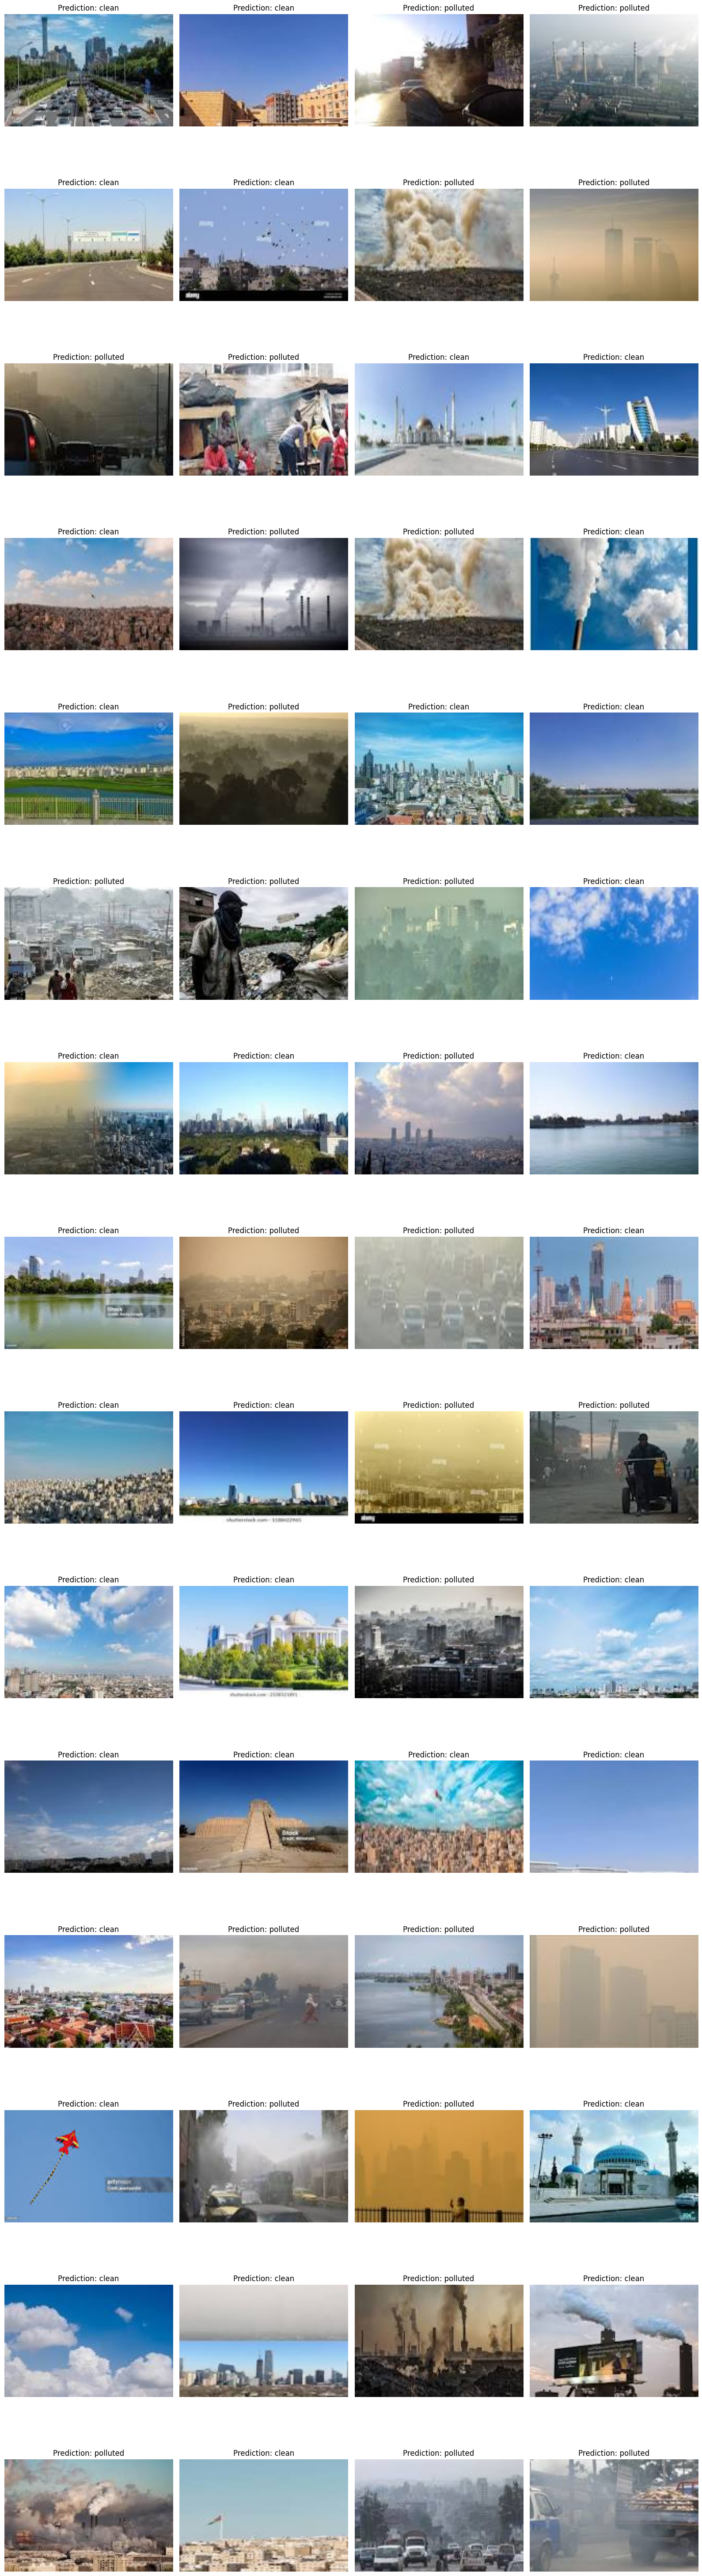

In [ ]:
# Plot predictions
num_images = len(images)
num_cols = 4
num_rows = (num_images + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))
axes = axes.flatten()

for i, img_name in enumerate(images):
    img_path = os.path.join(folder_path, img_name)
    result = predict_air_quality(img_path, loaded_model, device)

    img = Image.open(img_path).resize((162, 108))  # For display
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Prediction: {result}')

# Hide extra axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()